## 3.2 全球气温异常值

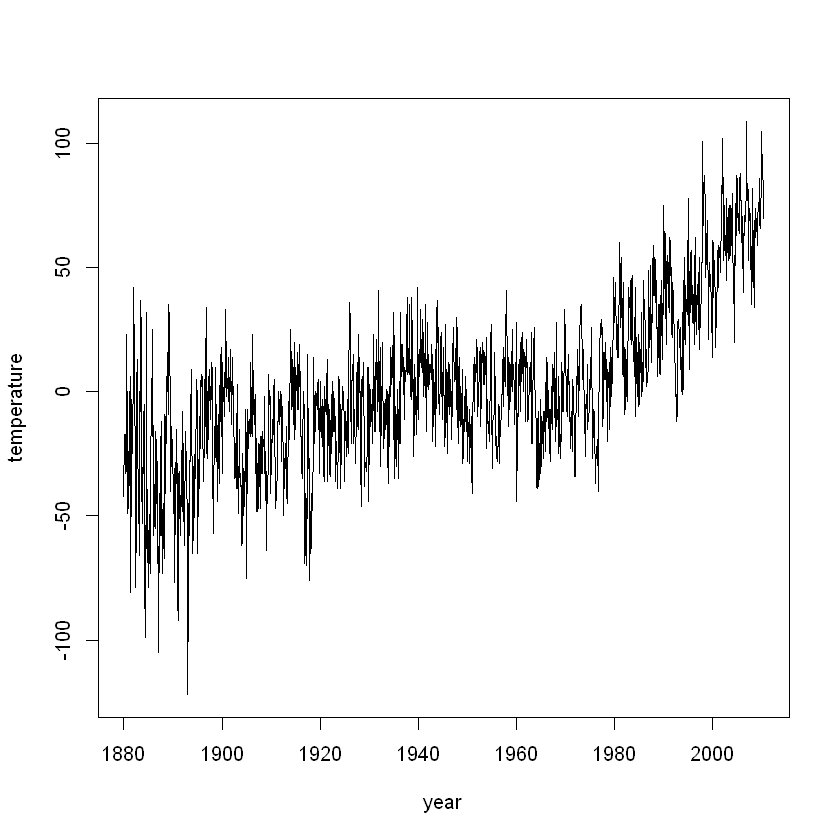

In [1]:
Gt <- scan(file = "data/m-GLBTs.txt")
Gtemp <- ts(Gt, frequency = 12, start = c(1880, 1))
plot(Gtemp, xlab = "year", ylab = "temperature", type = "l")  # plot the data

上图显示了全球温度异常值的时序图。

### 3.2.1 单位根平稳
用$G_t$表示全球温度异常值的月数据。为了设定序列$G_t$的模型，我们首先检验该序列的动态相依关系。

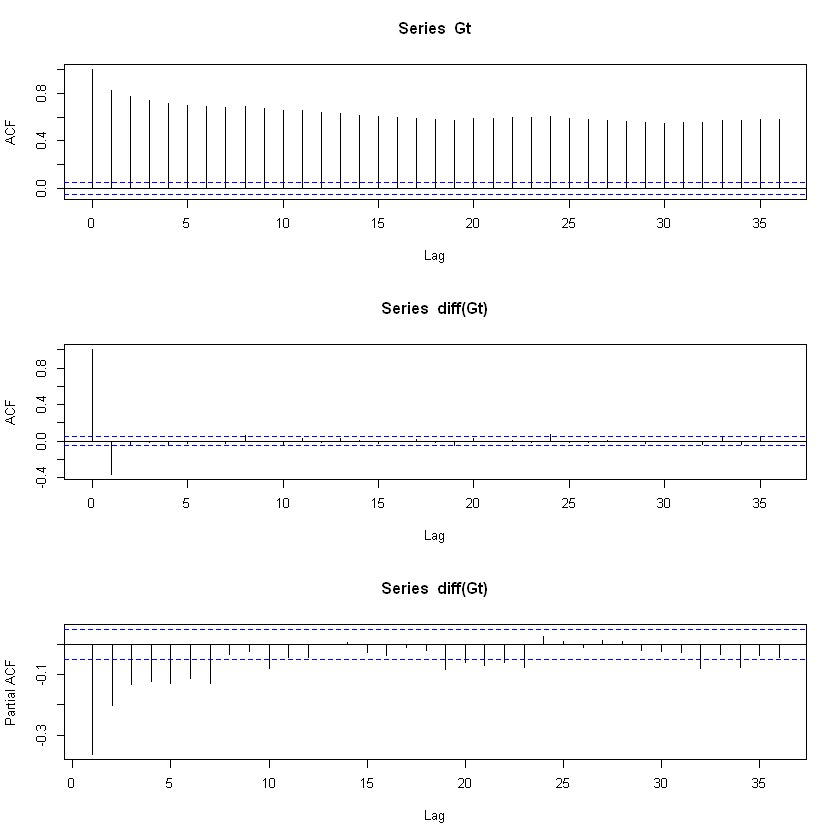

In [2]:
par(mfcol = c(3, 1))
acf(Gt, lag = 36)
acf(diff(Gt), lag = 36)
pacf(diff(Gt), lag = 36)

从$G_t$的ACF图中我们可以看出该样本自相关函数具有很大的数值，且缓慢衰减。       
由于存在很强的序列相关性，我们考虑其差分数据，$x_t=(1-B)G_t$。   
从$x_t$的ACF图和PACF图中看出可以用一个平稳时间序列模型来对$x_t$进行近似。由于样本数据很多，共有1568个，所以我们可以使用相对复杂的模型来建模。从$x_t$的ACF和PACF中我们可以看出：              
* 自相关函数在滞后阶数为1、2、4、5、8时数值略为显著；        
* 自相关函数在滞后阶数为24时也是显著的。          
另一方面，样本PACF也存在几个显著的数值，尤其是1阶滞后PACF远远大于其他阶的PACF，并且PACF并不以指数衰减。

In [3]:
library(TSA)
eacf(diff(Gt), 6, 12)


Attaching package: 'TSA'

The following objects are masked from 'package:stats':

    acf, arima

The following object is masked from 'package:utils':

    tar



AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12
0 x o o o o o o x o o o  o  o 
1 x x o o o o o x o x o  o  o 
2 x x x o o o o o o o o  o  o 
3 x x x x o o o o o o o  o  o 
4 x x x o o o x o o o o  o  o 
5 x x x o x o x o o o o  o  o 
6 x x x o x x x o o o o  o  o 


<span class="mark">可不可以对$G_t$选择ARIMA(0, 1, 1)模型。</span>

对于序列$G_t$选择ARIMA(1,1,2)模型：
          
$$
(1-\phi B)(1-B)G_t=(1-\theta_1B-\theta_2B^2)a_t
$$ 
            
这里，<span class="mark">因为差分序列$x_t$的PACF在滞后阶数为1时较大，所以选择$p=1$</span>，并且因为$x_t$的自相关函数的前2阶是显著的，所以选择$q=2$。由于设定MA(2)模型可以有低阶滞后上显著的PACF，所以这里决定保持$p=1$。为了尽可能保持模型简化，ACF的高阶项暂时忽略，模型的拟合为
    
$$
(1-0.7387B)(1-B)G_t=(1-1.2973B+0.318B^2)a_t
$$
       

In [4]:
m1 <- arima(Gt, order = c(1, 1, 2))
m1


Call:
arima(x = Gt, order = c(1, 1, 2))

Coefficients:
         ar1      ma1     ma2
      0.7387  -1.2973  0.3183
s.e.  0.0406   0.0533  0.0492

sigma^2 estimated as 272.1:  log likelihood = -6616.56,  aic = 13239.11

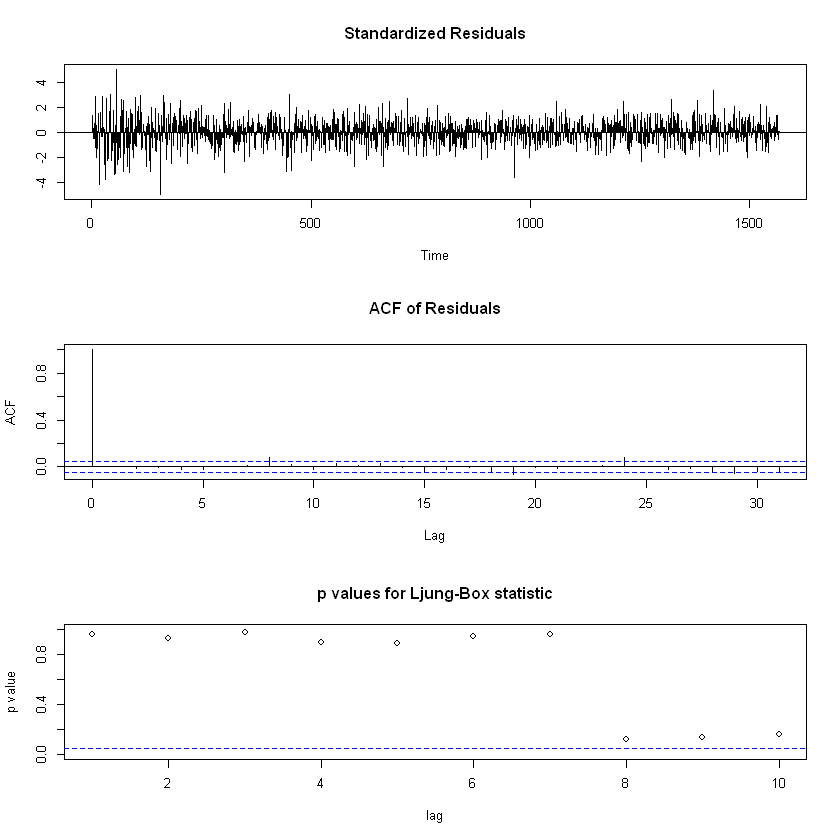

In [5]:
tsdiag(m1, gol = 36)

根据残差的ACF，该模型是不充分的，因为ACF在滞后阶数8和24上是显著的。                    
下面进行模型的改进。由于温度具有季节特征，所以ACF在滞后阶数为24时显著是可以理解的。另一方面，在滞后阶数为8时存在序列相关是不容易解释的，我们改进模型：
                  
$$
(1-\phi B)(1-B)G_t=(1-\theta_1B-\theta_2B^2)(1-\theta_{24}B^{24})a_t
$$
   

In [6]:
m1 <- arima(Gt, order = c(1, 1, 2), seasonal = list(order = c(0, 0, 1), period = 24))
m1


Call:
arima(x = Gt, order = c(1, 1, 2), seasonal = list(order = c(0, 0, 1), period = 24))

Coefficients:
         ar1      ma1     ma2    sma1
      0.7612  -1.3241  0.3416  0.0717
s.e.  0.0379   0.0519  0.0485  0.0243

sigma^2 estimated as 270.6:  log likelihood = -6612.2,  aic = 13232.4

拟合的模型为：

$$
(1-0.761B)(1-B)G_t=(1-1.324B+0.342B)(1+0.072B^{24})a_t
$$

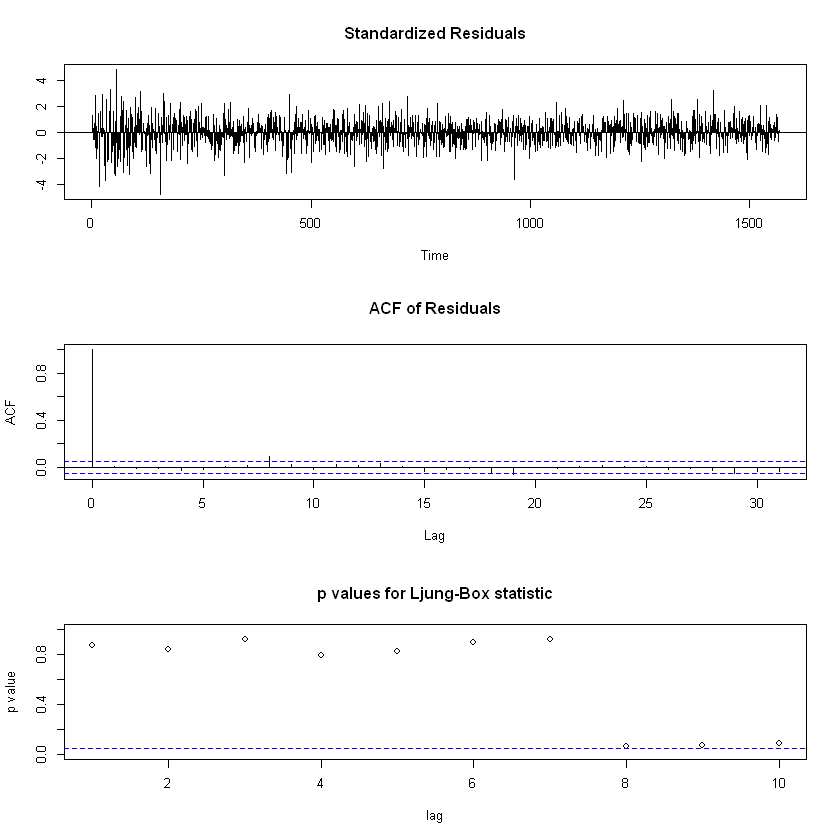

In [7]:
tsdiag(m1, gol = 36)

### 3.2.2 趋势非平稳
有些分析师和科学家利用时间趋势(time trend)对全球温度异常值进行建模。所谓时间趋势，是指我们利用时间指标作为解释变量。考虑如下模型：
            
$$
G_t=\beta_0+\beta_1t+z_t
$$  
      
这里$z_t$是一个新息序列，表示全球温度异常值与时间趋势之差的偏差。如果$z_t$是平稳时间序列，则$G_t$称为趋势平稳时间序列，也就是说通过移除时间趋势的影响，把序列转换为一个平稳序列。

In [8]:
time <- c(1:1568)
m2 <- lm(Gt ~ time)
summary(m2)


Call:
lm(formula = Gt ~ time)

Residuals:
    Min      1Q  Median      3Q     Max 
-92.055 -15.634   0.194  15.296  78.751 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -38.039763   1.134960  -33.52   <2e-16 ***
time          0.051560   0.001253   41.15   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 22.46 on 1566 degrees of freedom
Multiple R-squared:  0.5195,	Adjusted R-squared:  0.5192 
F-statistic:  1693 on 1 and 1566 DF,  p-value: < 2.2e-16


对于全球温度异常数据，拟合的线性模型为：
           
$$
G_t=-38.04+0.05156t+z_t
$$

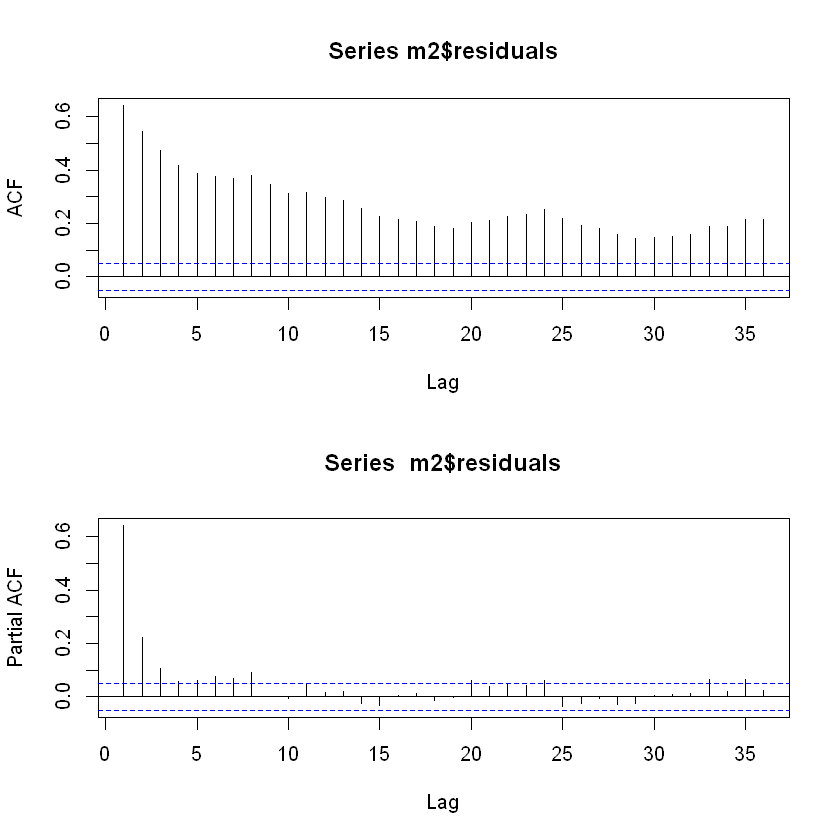

In [9]:
par(mfcol = c(2, 1))
acf(m2$residuals, lag = 36)
pacf(m2$residuals, lag = 36)

In [10]:
eacf(m2$residuals, 6, 12)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12
0 x x x x x x x x x x x  x  x 
1 x o o o o o o x o o o  o  o 
2 x o o o o o o x o x o  o  o 
3 x o x o o o o o o o o  o  o 
4 x x x x o o o x o o o  o  o 
5 x x x o x o x o o o o  o  o 
6 x x x o x o x o o o o  o  o 


m2 <- arima(Gt, order = c(2, 0, 1), xreg = time)
m2

In [11]:
tsdiag(m2, gof = 36)

ERROR: Error in UseMethod("tsdiag"): "tsdiag"没有适用于"lm"目标对象的方法


In [12]:
m2 <- arima(Gt, order = c(2, 0, 1), seasonal = list(order = c(0, 0, 1), period = 24), xreg = time)
m2


Call:
arima(x = Gt, order = c(2, 0, 1), seasonal = list(order = c(0, 0, 1), period = 24), 
    xreg = time)

Coefficients:
         ar1      ar2      ma1    sma1  intercept    xreg
      1.1960  -0.2394  -0.7451  0.0856   -38.7150  0.0529
s.e.  0.0587   0.0482   0.0486  0.0241     5.1843  0.0057

sigma^2 estimated as 270.8:  log likelihood = -6616.72,  aic = 13245.45

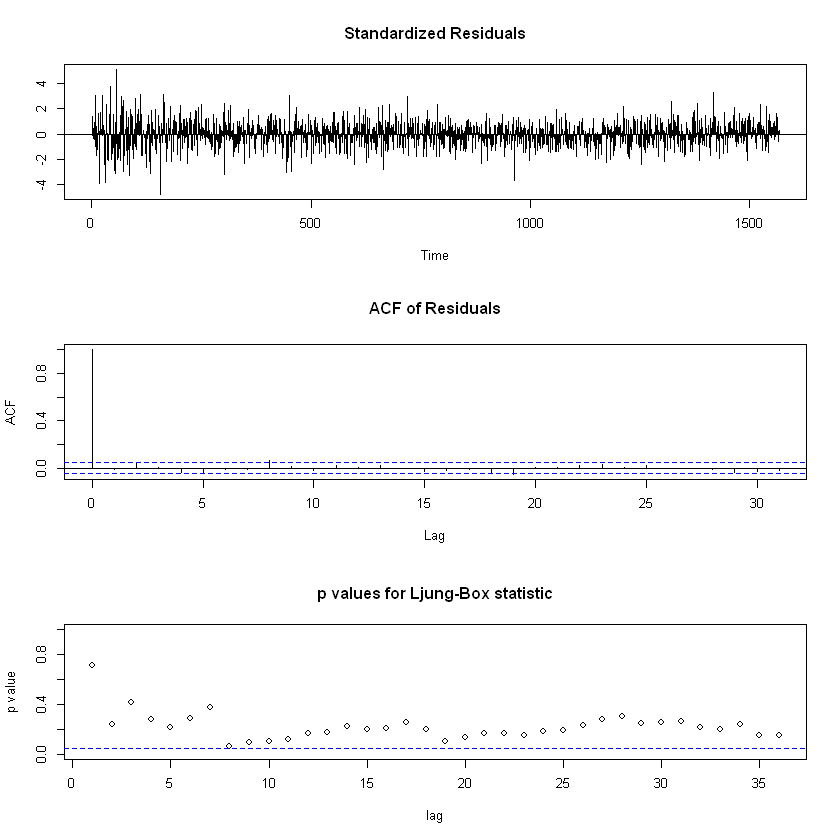

In [13]:
tsdiag(m2, gof = 36)

### 3.2.3 模型比较

In [14]:
source("backtest.R")
pm1 <- backtest(m1, Gt, 1368, 1)

[1] "RMSE of out-of-sample forecasts"
[1] 14.52598
[1] "Mean absolute error of out-of-sample forecasts"
[1] 11.16746


In [15]:
time <- as.matrix(time)
pm2 <- backtest(m2, Gt, 1368, 1, xre = time)

[1] "RMSE of out-of-sample forecasts"
[1] 15.34131
[1] "Mean absolute error of out-of-sample forecasts"
[1] 11.96595
